# Import packages

In [18]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
sys.path.append("..")
from utils import *

import cv2

# Helpers functions

In [19]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

# Load images

In [20]:
root_dir = "../../data/training/"

image_dir = root_dir + "images/"

files = os.listdir(image_dir)
n = min(20, len(files)) #load max 5 images

print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
n_train = 3 #use 3 images for training

Loading 20 images
Loading 20 images


# Info

Image size = 400,400


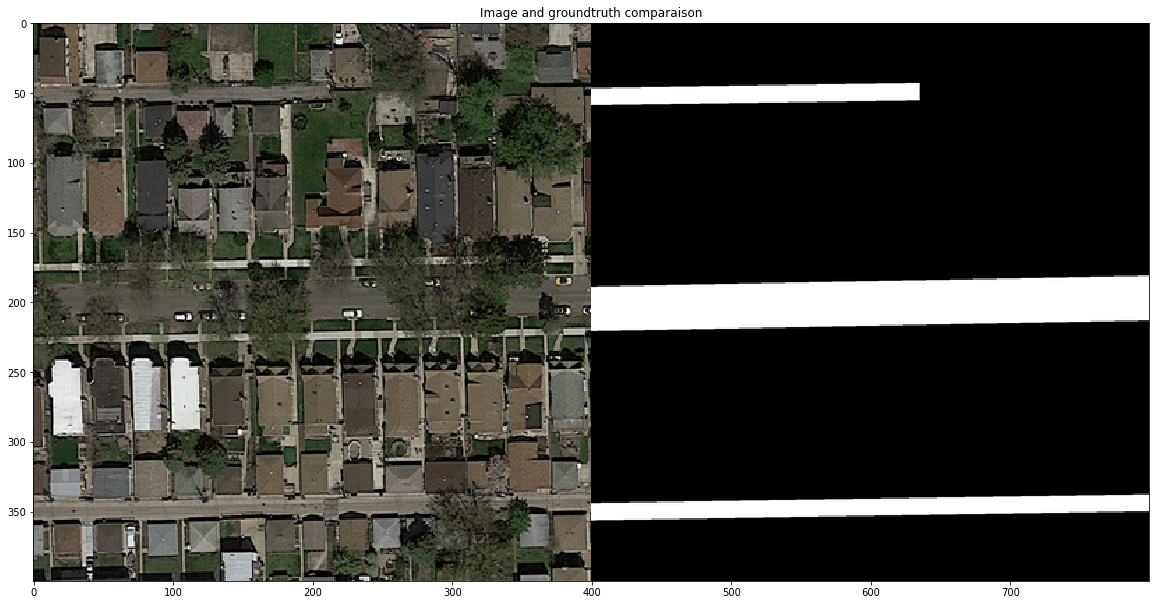

In [26]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))
cimg = concatenate_images(imgs[16], gt_imgs[16])
fig1 = plt.figure(figsize=(20, 20))
plt.title('Image and groundtruth comparaison')
plt.imshow(cimg, cmap='Greys_r')

# Shows patches

In [29]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
print(img_patches.shape)

(625, 16, 16, 3)


# Apply edge to paches

patches shapes (12500, 16, 16, 3)


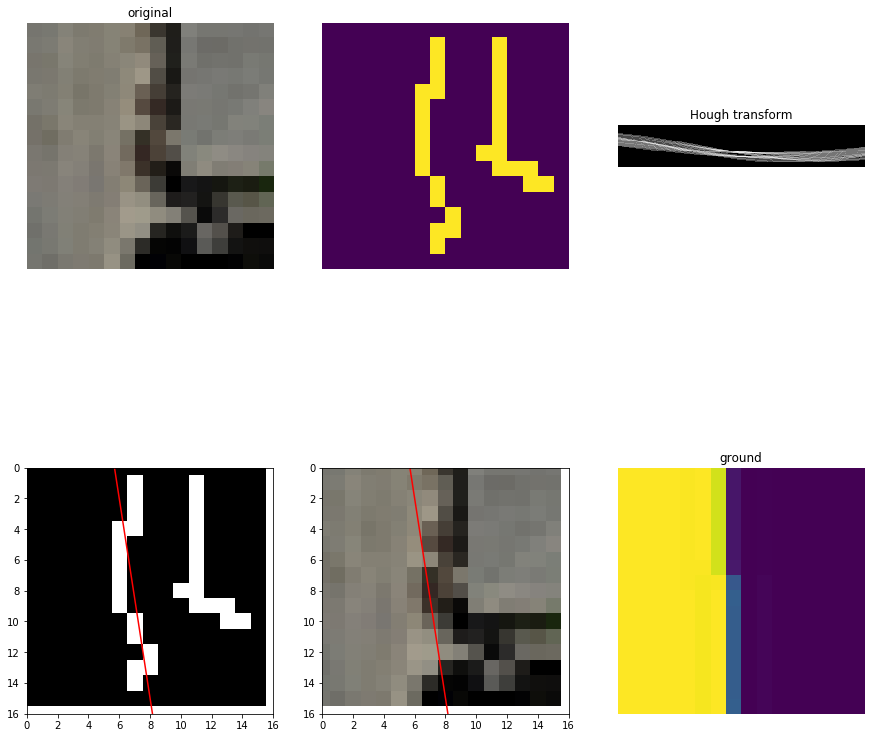

In [27]:
from skimage import feature
from skimage.color import rgb2gray

fig, axs = plt.subplots(2,3, figsize=(15,15))
print("patches shapes {0}".format(img_patches.shape))
image_number=1002

#original
axs[0, 0].imshow(img_patches[image_number])
axs[0, 0].set_title('original')
axs[0,0].set_axis_off()

#canny
sigma_ = 2
grayscale = rgb2gray(img_patches[image_number])
edges = feature.canny(grayscale, sigma=sigma_)
axs[0, 1].imshow(edges)
axs[0,1].set_axis_off()

#Hough scikit
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(edges, theta=tested_angles)

axs[0,2].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
axs[0,2].set_title('Hough transform')
axs[0,2].set_axis_off()

axs[1,0].imshow(edges, cmap=cm.gray)
origin = np.array((0, edges.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    axs[1,0].plot(origin, (y0, y1), '-r')
    break
axs[1,0].set_xlim(origin)
axs[1,0].set_ylim((edges.shape[0], 0))

## Hough on image
axs[1,1].imshow(img_patches[image_number], cmap=cm.gray)
origin = np.array((0, edges.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    axs[1,1].plot(origin, (y0, y1), '-r')
    break
axs[1,1].set_xlim(origin)
axs[1,1].set_ylim((edges.shape[0], 0))


#ground
axs[1, 2].imshow(gt_patches[image_number])
axs[1,2].set_title('ground')
axs[1,2].set_axis_off()


## Apply to all patches

In [31]:
print("patches shape:{0}".format(img_patches.shape))
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
sigma_ = 2
edge_patches = []
for patch in img_patches:
    grayscale = rgb2gray(patch)
    edges = feature.canny(grayscale, sigma=sigma_)
    h, theta, d = hough_line(edges, theta=tested_angles)
    
    origin = np.array((0, edges.shape[1]))
    line_image = np.copy(patch) * 0
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        axs[1,0].plot(origin, (y0, y1), '-r')
        cv2.line(line_image,(origin[0], int(y0)), (origin[1], int(y1)),(0,255,0),1)
        break
    edge_patches.append(line_image)

patches shape:(625, 16, 16, 3)


In [ ]:
fig, axs = plt.subplots(25,25,figsize=(20,20))
image_number = 16
for j in range(0,25):
    for i in range(0,25):
        axs[i,j].imshow(edge_patches[j*(25*image_number)+(i*image_number)]/255)
        axs[i,j].set_axis_off()
